In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import roc_curve, precision_score, recall_score, f1_score, accuracy_score, auc
from xgboost import plot_importance
from xgboost import XGBClassifier


### Data Modeling

#### Normalization : MinMaxScaler

In [2]:
d_final = pd.read_csv('d_final.csv', encoding = 'utf-8')

In [3]:
d_final.head()

,id,sex,intubed,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,...,tobacco,contact_other_covid,covid_res,icu,DEATH,d_ent,d_sym,d_last,diff_days,age_grp
0,167386,1,2,2,54,2,2,2,2,2,...,2,3,1,2,0,2020-04-06,2020-04-01,2020-06-29,89,3.0
1,0b5948,2,2,1,30,2,2,2,2,2,...,2,3,1,2,0,2020-04-17,2020-04-10,2020-06-29,80,2.0
2,0d01b5,1,2,2,60,2,1,2,2,2,...,2,3,1,2,1,2020-04-13,2020-04-13,2020-04-22,9,4.0
3,1beec8,2,2,1,47,2,1,2,2,2,...,2,3,1,1,1,2020-04-16,2020-04-16,2020-04-29,13,3.0
4,1.75E+56,2,2,2,63,2,2,2,2,2,...,2,3,1,2,0,2020-04-22,2020-04-13,2020-06-29,77,4.0


In [4]:
# 정규화할 변수만 d_normal0에 저장
d_normal0 = d_final.loc[:, ['sex', 'intubed', 'pneumonia', 'age_grp', 'pregnancy', 'diabetes', 'copd', 'asthma', 'inmsupr',
                            'hypertension', 'other_disease', 'obesity', 'cardiovascular', 'renal_chronic', 
                            'tobacco', 'contact_other_covid', 'covid_res', 'icu']]

# y(종속변수)는 정규화 하지않고 따로 저장
d_y = d_final.loc[:, ['DEATH', 'diff_days']]

In [5]:
# 정규화
d_normal = MinMaxScaler(feature_range=(0,1)).fit_transform(d_normal0)
d_normal

array([[0.        , 0.01020408, 0.5       , ..., 1.        , 0.        ,
        0.5       ],
       [1.        , 0.01020408, 0.        , ..., 1.        , 0.        ,
        0.5       ],
       [0.        , 0.01020408, 0.5       , ..., 1.        , 0.        ,
        0.5       ],
       ...,
       [1.        , 0.        , 0.        , ..., 0.5       , 1.        ,
        0.        ],
       [0.        , 0.01020408, 0.        , ..., 1.        , 1.        ,
        0.5       ],
       [0.        , 0.01020408, 0.        , ..., 1.        , 1.        ,
        0.5       ]])

#### Train, Test set 분리

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(d_normal, d_y, shuffle = True, random_state = 1004)

In [7]:
print(X_train.shape[:],'\n', X_test.shape[:], '\n', Y_train.shape[:], '\n', Y_test.shape[:])  

(91046, 18) 
 (30349, 18) 
 (91046, 2) 
 (30349, 2)


#### Emsemble model - XGBoost
- 모델 사용 이유 : kaggle 등에서 성능이 좋아서 최근 많이 쓰임
- Gradient Boosting model 보다 계산 속도 빠름
- 참고 : https://lsjsj92.tistory.com/547

##### XGBoost Hyper Parameter Tuning
- Grid Search 방법으로 XGBoost Hyper Parameter Tuning함
- https://m.blog.naver.com/PostView.nhn?blogId=gustn3964&logNo=221431933811&proxyReferer=https:%2F%2Fwww.google.com%2F
- https://m.blog.naver.com/gustn3964/221431963819

In [19]:
# Model Building

xgb = XGBClassifier()

xgb_params_grid = {
    'n_estimators' : [100, 200, 300, 400, 500], # 결정 트리 개수
    'learning_rate' : [0.001, 0.01, 0.05, 0.10, 0.15, 0.2], # 학습률
    'max_depth' : [4, 6, 8, 10 ,12], # 트리 깊이
    'random_state' : [1004] # seed 설정
}

xgb_model = GridSearchCV(xgb, param_grid = xgb_params_grid, 
                        scoring = "accuracy", 
                        cv = KFold(5, random_state = 1004), # 5-fold CV 수행
                        n_jobs = -1, # 병렬 처리 개수 : -1은 전부
                        verbose = 1)



C:\ProgramData\Anaconda3\envs\py37_tf2\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [20]:
# Model Learning
%time
Y_train1 = Y_train.loc[:, "DEATH"]
xgb_model.fit(X_train, Y_train1)

Wall time: 0 ns
Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 45.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 104.2min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed: 171.1min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=1004, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, m...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
             

In [21]:
# 최적 parameter 확인
print("Best parameters (5-fold CV, gird search): " , xgb_model.best_params_)
print("Best accuracy (5-fold CV, gird search): " , xgb_model.best_score_)

Best parameters (5-fold CV, gird search):  {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 300, 'random_state': 1004}
Best accuracy (5-fold CV, gird search):  0.7755529537158532


In [22]:
cv_result_df = pd.DataFrame(xgb_model.cv_results_)
cv_result_df.sort_values(by=['rank_test_score'], inplace=True)

In [23]:
cv_result_df[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
52,"{'learning_rate': 0.05, 'max_depth': 4, 'n_est...",0.775553,1
76,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",0.775531,2
77,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",0.775509,3
53,"{'learning_rate': 0.05, 'max_depth': 4, 'n_est...",0.775465,4
51,"{'learning_rate': 0.05, 'max_depth': 4, 'n_est...",0.775443,5


In [129]:
# 최적 parameter로 xgboost 모델 생성 및 예측
xgb_best = xgb_model.best_estimator_
Y_pred = xgb_best.predict(X_test) ; Y_pred # 예측값

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

### Test set 성능 평가
- Test set에서의 결과 평가
- 개념설명은 https://bcho.tistory.com/1206 참고
- https://datascienceschool.net/view-notebook/731e0d2ef52c41c686ba53dcaf346f32/

In [144]:
Y_test1 = Y_test.loc[:, "DEATH"] # True 값

In [145]:
print('accuracy : %.3f' % accuracy_score(y_true = Y_test1, y_pred=Y_pred))
print('recall : %.3f' % recall_score(y_true = Y_test1, y_pred=Y_pred))
print('f1_score : %.3f' % f1_score(y_true = Y_test1, y_pred=Y_pred))

accuracy : 0.776
recall : 0.364
f1_score : 0.464


#### ROC curve 작성

In [130]:
f_value = xgb_best.fit(X_test,Y_test1).predict_proba(X_test) # 분류 확률

fpr, tpr, thresholds = roc_curve(Y_test1, f_value[:,1])
fpr, tpr, thresholds

(array([0.        , 0.        , 0.        , ..., 0.9998652 , 0.99995507,
        1.        ]),
 array([0.00000000e+00, 1.23563573e-04, 4.94254294e-04, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 array([1.9220507 , 0.9220507 , 0.8805111 , ..., 0.00356295, 0.00331689,
        0.00220519], dtype=float32))

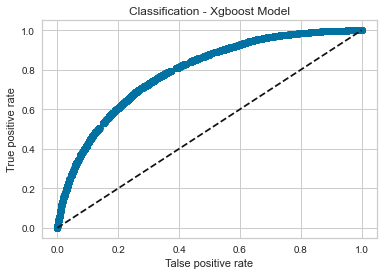

In [138]:
plt.plot(fpr, tpr, 'o-', label="Xgboost (AUC=%0.3f)")
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.xlabel('Talse positive rate')
plt.ylabel('True positive rate')
plt.title('Classification - Xgboost Model')
plt.show()

In [149]:
print('AUC : %.3f' % auc(fpr, tpr))

AUC : 0.790
